In [1]:
from prepyto import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import ConnectionPatch
plt.rcParams.update({'font.size': 20})

unetmic: tensorflow is missing, some function will fail
blocks: tensorflow not found, some function will fail


/Users/bzuber/anaconda3/envs/DeepVesicles/lib/python3.9/site-packages/napari/_qt/__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


pipeline: tensorflow is not installed, some function will not work.


In [2]:
pl = Pipeline('115')

Prepyto Pipeline: the pipeline is created for /Users/bzuber/microscopic_anatomy Dropbox/Benoit Zuber/temp_only_copies/115


In [3]:
pl.set_array('image')
pl.set_array('deep_labels')

'deep_labels'

In [4]:
vesicle_regions = pd.DataFrame(skimage.measure.regionprops_table(pl.deep_labels,properties=('centroid', 'label', 'bbox')))
bboxes = get_bboxes_from_regions(vesicle_regions)
centroids = get_centroids_from_regions(vesicle_regions)
labels = get_labels_from_regions(vesicle_regions)
thicknesses, densities, radii, centers, kept_labels = [],[],[],[],[]

In [5]:
shifts = []
delta_radii = []
new_centroids = []
new_radii = []
for i in tqdm(range(len(labels))):
    label = labels[i]
    rounded_centroid = np.round(centroids[i]).astype(np.int)
    radius = get_label_largest_radius(bboxes[i])
    margin = 3
    _, _, new_centroid, new_optimal_radius, _ = get_sphere_parameters(pl.image, label, margin, radius, rounded_centroid)
    new_centroids.append(new_centroid)
    new_radii.append(new_optimal_radius)
    shift = new_centroid - rounded_centroid
    delta_radius = new_optimal_radius - radius
    shifts.append(shift)
    delta_radii.append(delta_radius)
new_centroids = np.array(new_centroids)
new_radii = np.array(new_radii)
shifts = np.array(shifts)
delta_radii = np.array(delta_radii)
distances = np.linalg.norm(shifts, axis=1)


100%|██████████| 181/181 [00:11<00:00, 15.99it/s]


In [9]:
from scipy.spatial import distance_matrix

In [185]:
rm = np.repeat(np.array((new_radii,)), len(new_radii),axis=0)
radii_matrix = rm + rm.T
dm = distance_matrix(new_centroids, new_centroids)
maxvalue = np.finfo(dm.dtype).max
for i in range(len(dm)):
    dm[i,i] = maxvalue
collisions = np.array((np.where(dm < radii_matrix)))
collision_counts = np.array(np.unique(collisions[0], return_counts=True))
collision_count_dict = {}
for x,y in collision_counts.T:
    collision_count_dict[x]=y

In [164]:
print(collisions.T)
print(collision_counts.T)

[[  0  39]
 [  6  15]
 [ 12  26]
 [ 14  15]
 [ 15   6]
 [ 15  14]
 [ 15  83]
 [ 16  26]
 [ 24  27]
 [ 24  66]
 [ 26  12]
 [ 26  16]
 [ 26  41]
 [ 27  24]
 [ 39   0]
 [ 41  26]
 [ 45  84]
 [ 48  93]
 [ 61  70]
 [ 66  24]
 [ 70  61]
 [ 72  86]
 [ 79  84]
 [ 80  84]
 [ 81  84]
 [ 81 104]
 [ 83  15]
 [ 84  45]
 [ 84  79]
 [ 84  80]
 [ 84  81]
 [ 84  87]
 [ 84  98]
 [ 84 104]
 [ 84 106]
 [ 84 123]
 [ 84 125]
 [ 84 136]
 [ 84 138]
 [ 84 144]
 [ 84 150]
 [ 84 157]
 [ 86  72]
 [ 87  84]
 [ 89 126]
 [ 90 111]
 [ 92 141]
 [ 93  48]
 [ 96 127]
 [ 98  84]
 [104  81]
 [104  84]
 [104 106]
 [106  84]
 [106 104]
 [110 114]
 [110 117]
 [111  90]
 [111 120]
 [113 126]
 [113 141]
 [113 156]
 [114 110]
 [115 120]
 [115 146]
 [117 110]
 [117 141]
 [120 111]
 [120 115]
 [123  84]
 [125  84]
 [126  89]
 [126 113]
 [127  96]
 [136  84]
 [138  84]
 [141  92]
 [141 113]
 [141 117]
 [142 160]
 [142 172]
 [144  84]
 [146 115]
 [150  84]
 [151 163]
 [156 113]
 [157  84]
 [160 142]
 [160 172]
 [162 169]
 [163 151]

(array([44., 12.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.]),
 <BarContainer object of 14 artists>)

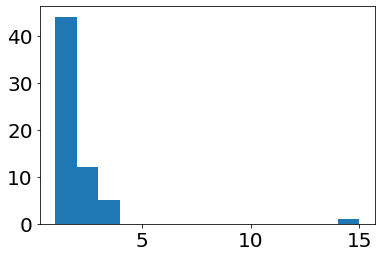

In [176]:
plt.hist(counts[1], bins=counts[1].max()-1)

distance: 6.09 ± 7.53
distance median : 3.16


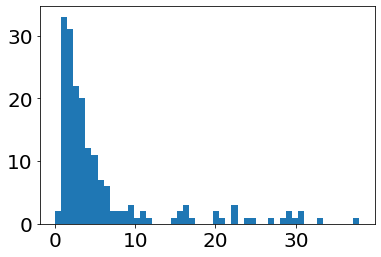

radial change: 3.17 ± 7.07
absoliute radial change media: 4.00


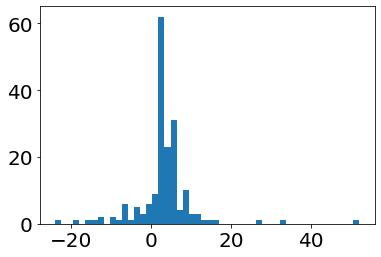

In [7]:



print(f"distance: {distances.mean():.2f} ± {distances.std():.2f}")
print(f"distance median : {np.median(distances):.2f}")
_= plt.hist(distances, bins=50)
plt.show()
print(f"radial change: {delta_radii.mean():.2f} ± {delta_radii.std():.2f}")
print(f"absoliute radial change media: {np.median(np.abs(delta_radii)):.2f}")
_ = plt.hist(delta_radii, bins=50)

In [169]:
def make_figure(i, savefig=False):
    fontsize = 32
    margin = 3
    radius = get_label_largest_radius(bboxes[i])  #this is an integer
    rounded_centroid = np.round(centroids[i]).astype(np.int) #this is an array of integers
    label = labels[i]
    image_box = extract_box_of_radius(pl.image, rounded_centroid, radius + margin)
    origin = None
    radial_profile = get_radial_profile(image_box, origin)
    i_membrane_center, _ = get_sphere_membrane_center_and_density_from_radial_profile(radial_profile)
    i_upper_limit = get_radial_profile_i_upper_limit(radial_profile)
    i_membrane_outer_halo = i_membrane_center + radial_profile[i_membrane_center:i_upper_limit].argmax()
    derivative2 = np.diff(radial_profile,2)
    filtered_derivative2 = ndimage.gaussian_filter1d(derivative2,1)
    optimal_radius = -1 + i_membrane_center + ndimage.gaussian_filter1d(derivative2[i_membrane_center:i_membrane_outer_halo+1],1).argmin()
    average_image = get_3d_radial_average(image_box, origin)
    _, _, new_centroid, new_optimal_radius, _ = get_sphere_parameters(pl.image, label, margin, radius, rounded_centroid)
    new_optimal_radius = new_optimal_radius - 1 
    shift = new_centroid - rounded_centroid
    new_image_box = extract_box_of_radius(pl.image, new_centroid, new_optimal_radius + margin+1)
    print(f"new image box shape is {new_image_box.shape}")
    print(f"new centroid is {new_centroid}")
    new_radial_profile = get_radial_profile(new_image_box,origin)
    new_average_image = get_3d_radial_average(new_image_box, origin)
    new_i_membrane_center, _ = get_sphere_membrane_center_and_density_from_radial_profile(new_radial_profile)
    new_i_upper_limit = get_radial_profile_i_upper_limit(new_radial_profile)
    new_i_membrane_outer_halo = new_i_membrane_center + new_radial_profile[new_i_membrane_center:new_i_upper_limit].argmax()
    new_derivative2 = np.diff(new_radial_profile,2)
    new_filtered_derivative2 = ndimage.gaussian_filter1d(new_derivative2,1)
    print(f"new_optimal_radius is {new_optimal_radius}")
    print(f"alternative calc: {-1 + new_i_membrane_center + new_filtered_derivative2[i_membrane_center:i_membrane_outer_halo+1].argmin()}")
    
    nx = 4
    ny = 2
    dxs = 8
    dys = 6
    theta = np.linspace(0, 2*np.pi, 100)
    xcircle = optimal_radius * np.cos(theta)
    ycircle = optimal_radius * np.sin(theta)
    new_xcircle = new_optimal_radius * np.cos(theta)
    new_ycircle = new_optimal_radius * np.sin(theta)
    
    fig, ax = plt.subplots(nrows=ny,ncols=nx, figsize=(nx*dxs,ny*dys), facecolor='white')
    #fig.subplots_adjust(hspace=0.5)
    #fig.suptitle(f"i = {i},   shift = {shift},  radius difference = {new_optimal_radius - optimal_radius}, avg min,max = {average_image.min():.2f}, {average_image.max():.2f} ,  new_avg min,max = {new_average_image.min():.2f}, {new_average_image.max():.2f}")
    
    ax[0,1].plot(radial_profile)
    ax[0,1].set_xlabel('radius [pixel]')
    ax[0,1].set_ylabel('intensity')
    ylim = ax[0,1].get_ylim()
    ax[0,1].fill_between((i_membrane_center,i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[0,1].vlines(optimal_radius, ylim[0], ylim[1],color='red')
    ax[0,1].set_ylim(ylim)
    
    ax[0,2].plot(filtered_derivative2)
    ax[0,2].set_xlabel('radius [pixel]')
    ax[0,2].set_ylabel(r'$\frac{\partial^2 intensity}{\partial radius^2}$', fontsize=28)
    ylim = ax[0,2].get_ylim()
    ax[0,2].fill_between((i_membrane_center,i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[0,2].vlines(optimal_radius, ylim[0], ylim[1],color='red')
    ax[0,2].set_ylim(ylim)
    ax[0,2].set_xlim(ax[0,1].get_xlim())
    
    ax[1,1].plot(new_radial_profile)
    ax[1,1].set_xlabel('radius [pixel]')
    ax[1,1].set_ylabel('intensity')
    ylim = ax[1,1].get_ylim()
    ax[1,1].fill_between((new_i_membrane_center,new_i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[1,1].vlines(new_optimal_radius,ylim[0], ylim[1],color='red')
    ax[1,1].set_ylim(ylim)
    ax[1,1].set_xlim(ax[0,1].get_xlim())
    
    ax[1,2].set_xlabel('radius [pixel]')
    ax[1,2].set_ylabel(r'$\frac{\partial^2 intensity}{\partial radius^2}$', fontsize=28)
    ax[1,2].plot(new_filtered_derivative2)
    ylim = ax[1,2].get_ylim()
    ax[1,2].fill_between((new_i_membrane_center,new_i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[1,2].vlines(new_optimal_radius, ylim[0], ylim[1],color='red')
    ax[1,2].set_ylim(ylim)
    ax[1,2].set_xlim(ax[0,1].get_xlim())

    imgplt00 = ax[0,0].imshow(image_box[image_box.shape[0]//2])
    ax[0,0].set_xlabel('x-coordinate [pixel]')
    ax[0,0].set_ylabel('y-coordinate [pixel]')
    imgplt00.set_cmap('gray')
    xlim, ylim = (ax[0,0].get_xlim(), ax[0,0].get_ylim())
    ax[0,0].plot(xcircle+image_box.shape[1]//2, ycircle+image_box.shape[2]//2, color='red')
    ax[0,0].set_xlim(xlim)
    ax[0,0].set_ylim(ylim)
    
    imgplt01 = ax[0,3].imshow(-average_image[image_box.shape[0]//2])
    ax[0,3].set_xlabel('x-coordinate [pixel]')
    ax[0,3].set_ylabel('y-coordinate [pixel]')
    imgplt01.set_cmap('copper')
    xlim, ylim = (ax[0,3].get_xlim(), ax[0,3].get_ylim())
    ax[0,3].plot(xcircle+image_box.shape[1]//2, ycircle+image_box.shape[2]//2, color='red')
    ax[0,3].set_xlim(xlim)
    ax[0,3].set_ylim(ylim)
    
    imgplt10 = ax[1,0].imshow(new_image_box[new_image_box.shape[0]//2])
    ax[1,0].set_xlabel('x-coordinate [pixel]')
    ax[1,0].set_ylabel('y-coordinate [pixel]')
    imgplt10.set_cmap('gray')
    xlim, ylim = (ax[1,0].get_xlim(), ax[1,0].get_ylim())
    ax[1,0].plot(new_xcircle+new_image_box.shape[1]//2, new_ycircle+new_image_box.shape[2]//2, color='red')
    ax[1,0].set_xlim(xlim)
    ax[1,0].set_ylim(ylim)

    imgplt11 = ax[1,3].imshow(-new_average_image[new_image_box.shape[0]//2])
    ax[1,3].set_xlabel('x-coordinate [pixel]')
    ax[1,3].set_ylabel('y-coordinate [pixel]')
    imgplt11.set_cmap('copper')
    xlim, ylim = (ax[1,3].get_xlim(), ax[1,0].get_ylim())
    ax[1,3].plot(new_xcircle+new_image_box.shape[1]//2, new_ycircle+new_image_box.shape[2]//2, color='red')
    ax[1,3].set_xlim(xlim)
    ax[1,3].set_ylim(ylim)   

    ax[0,0].text(0.05, 0.95, "A", transform=ax[0,0].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[0,1].text(0.05, 0.95, "B", transform=ax[0,1].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[0,2].text(0.05, 0.95, "C", transform=ax[0,2].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[0,3].text(0.05, 0.95, "D", transform=ax[0,3].transAxes,fontsize=fontsize, fontweight='bold', va='top', color='white')
    ax[1,0].text(0.05, 0.95, "E", transform=ax[1,0].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[1,1].text(0.05, 0.95, "F", transform=ax[1,1].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[1,2].text(0.05, 0.95, "G", transform=ax[1,2].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[1,3].text(0.05, 0.95, "H", transform=ax[1,3].transAxes,fontsize=fontsize, fontweight='bold', va='top', color='white')
    
    fig.tight_layout(h_pad=7.5)
    
    ax[0,0].annotate(f"Initial radius = {radius}. Radius after inital radial profile = {optimal_radius}.\nShift [z x y] = {shift}\nFinal radius = {new_optimal_radius}", (1.1,-0.48), xycoords='axes fraction', annotation_clip=False, fontsize=24)
    
    xyA = (1, -.2)
    xyB = (1, 1.2)
    coordsA = "axes fraction"
    coordsB = "axes fraction"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax[0,0], axesB=ax[1,0],
                      arrowstyle="Simple, head_length=2, head_width=2",
                    facecolor="white", linewidth=3)
    ax[0,0].add_artist(con)
    print(f"i is {i}")
    if savefig:
        plt.savefig(f'fig{i:03d}.svg')
    else:
        plt.show()
          
          

new image box shape is (128, 128, 128)
new centroid is [114 464 495]
new_optimal_radius is 60
alternative calc: 41
i is 84


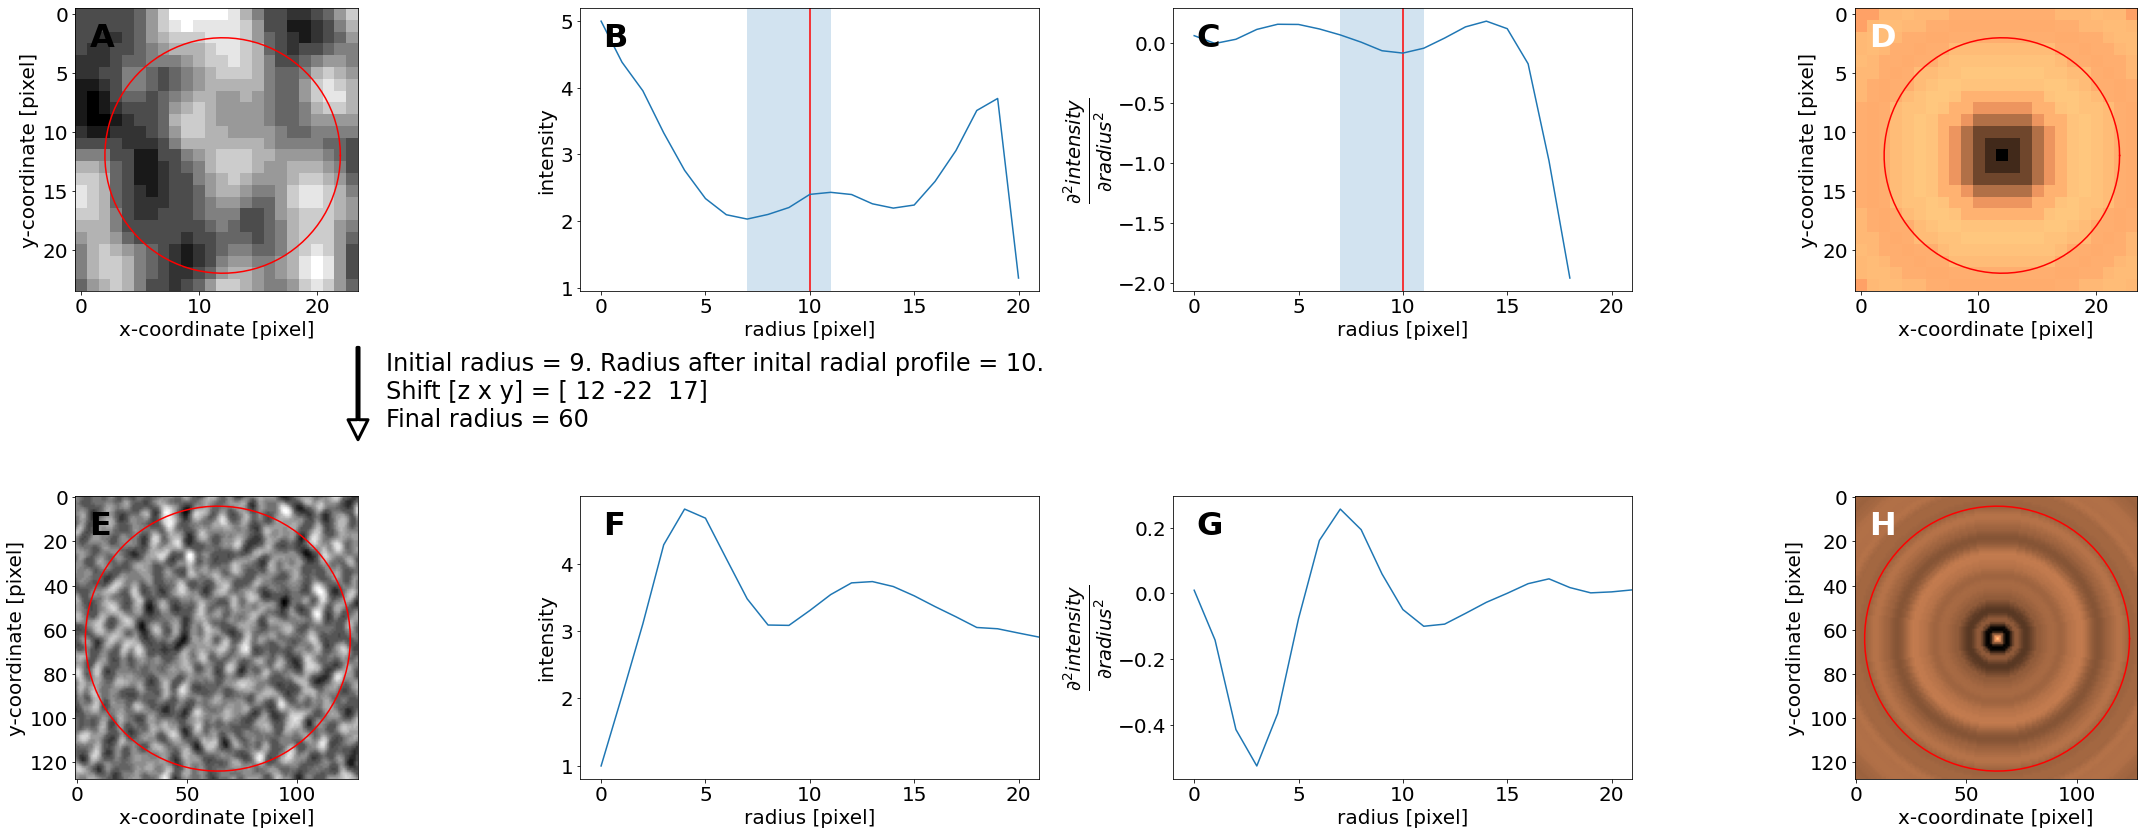

In [200]:
#i = next(i_s)
#print(f"i = {i}")
for k, count in collision_count_dict.items():
    if count ==15:
        make_figure(k)

In [ ]:
for i in (162,152,144,139,118,99):
    make_figure(i, savefig=True)

In [ ]:
for i in range(centroids.shape[0]):
    try:
        make_figure(i)
    except ValueError:
        print(f"missed {i}")

In [ ]:
for i in (11,):
    make_figure(i, savefig=True)
